In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
matplotlib.font_manager._rebuild()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

In [3]:
import os

# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(), # augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_valid = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './data_10'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'Training'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'Test'), transforms_test)
valid_datasets = datasets.ImageFolder(os.path.join(data_dir, 'Validation'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))
print('valid 데이터셋 크기:', len(valid_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 1140
테스트 데이터셋 크기: 154
valid 데이터셋 크기: 150
클래스: ['10015_롯데핫식스자몽250ML', '10016_동아오츠카데미소다자몽250ML', '30017_롯데밀키스250ML', '30033_코카콜라250ML', '40036_오란씨깔라만시250ML', '40049_코카환타오렌지250ML', '50012_일화맥콜250ML', '60009_롯데펩시콜라250ML', '60037_코카환타파인애플250ML', '90118_코카콜라)스프라이트250ML']


In [4]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 10개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/resnet_experiment_v1')

In [6]:
train_losses=[]
train_accu=[]

def train(epoch):
    model.train()

    # 전체 반복(epoch) 수 만큼 반복하며
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.
    
    train_losses.append(epoch_loss)
    train_accu.append(epoch_acc)
    
    writer.add_scalar("Loss/train", epoch_loss, epoch)
    writer.add_scalar("Accu/train", epoch_acc, epoch)

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))
    
    #######
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "./" + 'checkpoint_' + str(epoch) + '.tar')

In [7]:
eval_losses=[]
eval_accu=[]

def valid(epoch):
    model.eval()
    start_time = time.time()
    running_loss=0
    running_corrects=0
    total=0
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    
    eval_losses.append(epoch_loss)
    eval_accu.append(epoch_acc)
    
    writer.add_scalar("Loss/valid", epoch_loss, epoch)
    writer.add_scalar("Accu/valid", epoch_acc, epoch)
    
    print('[Validation Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

In [8]:
num_epochs = 10

start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    train(epoch)
    valid(epoch)

C:\Users\rhksd\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


#0 Loss: 1.5274 Acc: 44.5614% Time: 214.8090s
[Validation Phase] Loss: 2.1750 Acc: 59.0909% Time: 8.3767s
#1 Loss: 0.8203 Acc: 71.4035% Time: 441.3625s
[Validation Phase] Loss: 1.2707 Acc: 61.6883% Time: 8.4699s
#2 Loss: 0.4999 Acc: 83.8596% Time: 667.8126s
[Validation Phase] Loss: 1.5707 Acc: 57.7922% Time: 8.3894s
#3 Loss: 0.3469 Acc: 88.5088% Time: 902.7831s
[Validation Phase] Loss: 1.6792 Acc: 64.9351% Time: 8.0219s
#4 Loss: 0.2073 Acc: 93.4211% Time: 1126.6847s
[Validation Phase] Loss: 1.2436 Acc: 72.0779% Time: 8.2575s
#5 Loss: 0.2925 Acc: 91.3158% Time: 1351.0313s
[Validation Phase] Loss: 2.1942 Acc: 64.9351% Time: 8.4774s
#6 Loss: 0.1986 Acc: 93.9474% Time: 1575.7992s
[Validation Phase] Loss: 0.8969 Acc: 77.9221% Time: 8.7138s
#7 Loss: 0.1524 Acc: 94.8246% Time: 1802.8654s
[Validation Phase] Loss: 1.0781 Acc: 74.6753% Time: 8.5481s
#8 Loss: 0.1298 Acc: 95.9649% Time: 2031.3821s
[Validation Phase] Loss: 2.4122 Acc: 64.9351% Time: 8.7295s
#9 Loss: 0.1592 Acc: 95.4386% Time: 2255.

In [9]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        # print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        # imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

[Test Phase] Loss: 1.5297 Acc: 70.7792% Time: 7.8468s


In [10]:
torch.save(model, './res_v1.h5')

In [11]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [12]:
import torch
import torchvision
import torchsummary
torchsummary.summary(model, (3, 224, 224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

training 할 때 validation 과정을 거치지 않아 모델 비교가 불가 -> validation 과정 넣어보자  
이 후 learning curve 그려볼 것 - https://androidkt.com/calculate-total-loss-and-accuracy-at-every-epoch-and-plot-using-matplotlib-in-pytorch/

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


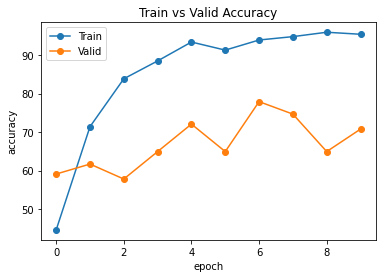

In [11]:
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

In [13]:
!tensorboard --logdir=runs

^C


In [14]:
##### 여기부턴 epoch 당 체크포인트 불러오는 과정

In [15]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 10개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 10)
model = model.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
checkpoint = torch.load('checkpoint_6.tar')

In [19]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [20]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        # print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        # imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

[Test Phase] Loss: 0.8969 Acc: 77.9221% Time: 7.8453s
